## Use stacked images (3D) and Densenet121 3D model

Acknowledgements:

- https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
- https://www.kaggle.com/davidbroberts/determining-dicom-image-order
- https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling
- https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train
- https://github.com/shijianjian/EfficientNet-PyTorch-3D

This notebook is based on the implementation of Densenet121 3D available here:
https://www.kaggle.com/mikecho/monai-v060-deep-learning-in-healthcare-imaging

It builds 4 models with only one MRI type, then ensembles all of them computing average probabilities


In [1]:
!pip install torchio

In [2]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

import torchio as tio

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import xgboost as xgb

In [3]:
if os.path.exists("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"):
    data_directory = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"
    input_monaipath = "/kaggle/input/monai-v060-deep-learning-in-healthcare-imaging/"
    landmarks_directory = "/kaggle/input/rsna-landmarks"
else:
    data_directory = "rsna-miccai-brain-tumor-radiogenomic-classification"
    input_monaipath = "monai-v060-deep-learning-in-healthcare-imaging"
    landmarks_directory = "rsna-landmarks"

model_paths = "models"
os.makedirs("models", exist_ok=True)

In [4]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE = 2
N_EPOCHS = 5
NUM_FOLDS = 5
SEED = 42
MIN_LR = 1e-6
LR = 0.0004
LR_DECAY = 0.9

sys.path.append(input_monaipath)

from monai.networks.nets.densenet import DenseNet121

In [5]:
TOTAL_EPOCHS = N_EPOCHS * len(mri_types) * NUM_FOLDS
TOTAL_EPOCHS

100

## Functions to load images

In [6]:
def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.min(data)==np.max(data):
        data = np.zeros((img_size,img_size))
        return data
    
    data = cv2.resize(data, (img_size, img_size))
    return data


def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    files = natural_sort(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"))
    every_nth = len(files) / num_imgs
    indexes = [min(int(round(i*every_nth)), len(files)-1) for i in range(0,num_imgs)]
    
    files_to_load = [files[i] for i in indexes]
    
    img3d = np.stack([load_dicom_image(f) for f in files_to_load]).T 
    
    img3d = img3d - np.min(img3d)
    if np.max(img3d) != 0:
        img3d = img3d / np.max(img3d)
    
    return np.expand_dims(img3d,0)


load_dicom_images_3d("00000", mri_type=mri_types[0]).shape

(1, 256, 256, 64)

In [7]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

## remove samples as described in https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/262046

In [8]:
samples_to_exclude = [109, 123, 709]

df = pd.read_csv(f"{data_directory}/train_labels.csv")
print("original shape", df.shape)
df = df[~df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", df.shape)
display(df)

original shape (585, 2)
new shape (582, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [9]:
# df = df.iloc[:16]

## Model and training classes

In [10]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, landmarks_dict=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.landmarks_dict = landmarks_dict
        self.split = split
          
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
            augs = [
                tio.HistogramStandardization(self.landmarks_dict)
            ]
            transforms = tio.Compose(augs)
            data = transforms(data) 
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
            #get_foreground = tio.ZNormalization.mean
            augs = [
                tio.RandomAnisotropy(p=0.25),              # make images look anisotropic 25% of times
                tio.HistogramStandardization(self.landmarks_dict),
                # TODO: crop only sometimes! this happens all the time which is risky
                # tio.CropOrPad((256, 256, 64)),            # tight crop around brain
                # TODO: calculate landmarks:
                # https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/Data_preprocessing_and_augmentation_using_TorchIO_a_tutorial.ipynb#scrollTo=85COw2H63PfH
                # too strong? (removes part of the scan!)
                # tio.ZNormalization(
                #     masking_method=get_foreground),        # zero mean, unit variance of foreground
                #   works!
                tio.RandomBlur(p=0.25),                    # blur 25% of times
                tio.RandomNoise(p=0.25),                   # Gaussian noise 25% of times
                tio.OneOf({                                # either
                    tio.RandomAffine(): 0.8,               # random affine
                    tio.RandomElasticDeformation(): 0.2,   # or random elastic deformation
                }, p=0.8),                                 # applied to 80% of images
                tio.RandomBiasField(p=0.3),                # magnetic field inhomogeneity 30% of times
                tio.OneOf({                                # either
                    tio.RandomMotion(): 1,                 # random motion artifact
                    tio.RandomSpike(): 2,                  # or spikes
                    tio.RandomGhosting(): 2,               # or ghosts
                }, p=0.5),                                 # applied to 50% of images
            ]
            transforms = tio.Compose(augs)
            data = transforms(data)

            # import matplotlib.pyplot as plt
            # fig, axs = plt.subplots(2)
            # axs[0].imshow(data[0, :, :, 32], vmin=0, vmax=1)
            # print(data.shape)
            # data = transforms(data)
            # print(data.shape)
            # axs[1].imshow(data[0, :, :, 32], vmin=0, vmax=1)
            # plt.show()
            # print("============")
            
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index], dtype=torch.float)}


In [11]:
def build_model():
    model = DenseNet121(spatial_dims=3, in_channels=1, out_channels=1)
    return model    

In [12]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MIN_LR, max_lr=LR, cycle_momentum=False)
        # self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = .0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(valid_loss)
            self.val_auc.append(valid_auc)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            if self.best_valid_score < valid_auc: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_auc, self.lastmodel
                )
                self.best_valid_score = valid_auc
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].clone().detach().float().to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets)
                
            loss.backward()

            sum_loss += loss.detach().item()
            
            self.optimizer.step()
            # for param_group in self.optimizer.param_groups:
            #     print(param_group['lr'])
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch["y"].to(self.device)

                output = torch.sigmoid(self.model(batch["X"].clone().detach().float().to(self.device)).squeeze(1))
                loss = self.criterion(output, targets)
                sum_loss += loss.detach().item()

                y_all.extend(batch["y"].tolist())
                outputs_all.extend(output.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

# Prediction

In [13]:
def predict(model, df, mri_type, split):
    print("Predict:", mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    
    landmarks = torch.load(os.path.join(landmarks_directory, (f"{mri_type}_landmarks.npy")))
    landmarks_dict = {
        "default_image_name": landmarks,
    }

    data_retriever = Dataset(
        paths=df["BraTS21ID"].values,
        mri_type=df["MRI_Type"].values,
        split=split,
        landmarks_dict=landmarks_dict
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].clone().detach().float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    return y_pred

## train loop

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df, df_test, mri_type, skf):

    oof_train = np.zeros((len(df)))
    oof_test = np.zeros((len(df_test)))
    oof_test_skf = np.empty((5, len(df_test)))

    lastmodels = []
    for i, (train_index, val_index) in enumerate(skf.split(df, df["MGMT_value"], df["MGMT_value"])):
        df_train = df.iloc[train_index]
        df_valid = df.iloc[val_index]
        
        train = df_train.copy()
        valid = df_valid.copy()
        train.loc[:,"MRI_Type"] = mri_type
        valid.loc[:,"MRI_Type"] = mri_type

        print(train.shape, valid.shape)
        display(valid.head())
        print(len(train))
        display(valid.head())
        print(len(valid))

        landmarks = torch.load(os.path.join(landmarks_directory, (f"{mri_type}_landmarks.npy")))
        landmarks_dict = {
            "default_image_name": landmarks,
        }

        train_data_retriever = Dataset(
            train["BraTS21ID"].values, 
            train["MGMT_value"].values, 
            train["MRI_Type"].values,
            landmarks_dict=landmarks_dict
        )

        valid_data_retriever = Dataset(
            valid["BraTS21ID"].values, 
            valid["MGMT_value"].values,
            valid["MRI_Type"].values,
            landmarks_dict=landmarks_dict
        )

        train_loader = torch_data.DataLoader(
            train_data_retriever,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=8,
        )

        valid_loader = torch_data.DataLoader(
            valid_data_retriever, 
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=8,
        )

        model = build_model()
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        criterion = torch_functional.binary_cross_entropy_with_logits

        trainer = Trainer(
            model, 
            device, 
            optimizer, 
            criterion
        )

        history = trainer.fit(
            N_EPOCHS, 
            train_loader, 
            valid_loader, 
            f"models/{mri_type}", 
            N_EPOCHS,
        )

        trainer.display_plots(mri_type)

        oof_train[val_index] = predict(model, df_valid, mri_type, "train")
        oof_test_skf[i, :] = predict(model, df_test, mri_type, "test")

        lastmodels.append(trainer.lastmodel)

    oof_test = oof_test_skf.mean(axis=0)

    return oof_train, oof_test, lastmodels

In [15]:
df_test = pd.read_csv(f"{data_directory}/sample_submission.csv")
df_test["MGMT_value"] = 0

In [16]:
rkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,FLAIR
9,14,1,FLAIR
11,18,0,FLAIR
18,26,1,FLAIR
24,35,1,FLAIR


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,FLAIR
9,14,1,FLAIR
11,18,0,FLAIR
18,26,1,FLAIR
24,35,1,FLAIR


117
EPOCH: 1
[Epoch Train: 1] loss: 0.6918, time: 246.00 s
[Epoch Valid: 1] loss: 0.7153, auc: 0.4947, time: 63.00 s
auc improved from 0.0000 to 0.4947. Saved model to 'models/FLAIR-e1-loss0.715-auc0.495.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6938, time: 243.00 s
[Epoch Valid: 2] loss: 0.7178, auc: 0.5437, time: 60.00 s
auc improved from 0.4947 to 0.5437. Saved model to 'models/FLAIR-e2-loss0.718-auc0.544.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6890, time: 249.00 s
[Epoch Valid: 3] loss: 0.7176, auc: 0.5076, time: 63.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6846, time: 241.00 s
[Epoch Valid: 4] loss: 0.7099, auc: 0.5457, time: 61.00 s
auc improved from 0.5437 to 0.5457. Saved model to 'models/FLAIR-e4-loss0.710-auc0.546.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.6882, time: 239.00 s
[Epoch Valid: 5] loss: 0.7109, auc: 0.5622, time: 57.00 s
auc improved from 0.5457 to 0.5622. Saved model to 'models/FLAIR-e5-loss0.711-auc0.562.pth'


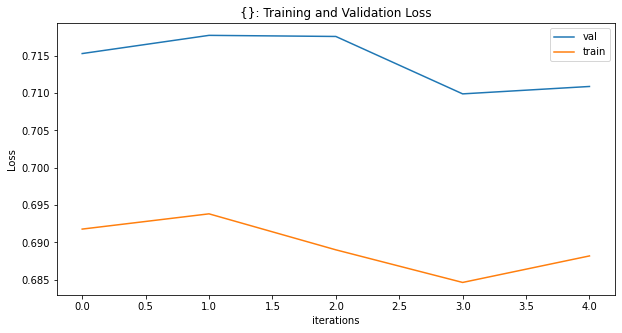

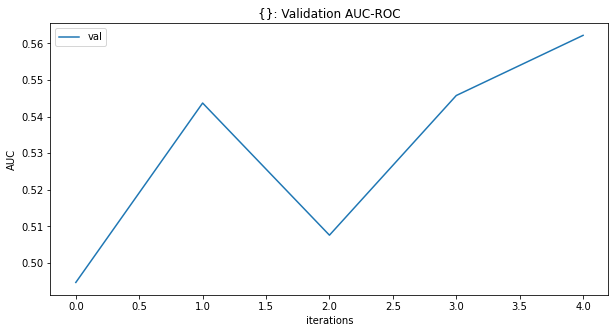

Predict: FLAIR (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 2)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,FLAIR
20,30,0,FLAIR
22,32,0,FLAIR
32,52,1,FLAIR
39,61,0,FLAIR


465


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,FLAIR
20,30,0,FLAIR
22,32,0,FLAIR
32,52,1,FLAIR
39,61,0,FLAIR


117
EPOCH: 1
[Epoch Train: 1] loss: 0.6953, time: 241.00 s
[Epoch Valid: 1] loss: 0.7208, auc: 0.5193, time: 60.00 s
auc improved from 0.0000 to 0.5193. Saved model to 'models/FLAIR-e1-loss0.721-auc0.519.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6929, time: 243.00 s
[Epoch Valid: 2] loss: 0.7165, auc: 0.5509, time: 73.00 s
auc improved from 0.5193 to 0.5509. Saved model to 'models/FLAIR-e2-loss0.717-auc0.551.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6898, time: 249.00 s
[Epoch Valid: 3] loss: 0.7190, auc: 0.5114, time: 74.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6907, time: 246.00 s
[Epoch Valid: 4] loss: 0.7220, auc: 0.4953, time: 59.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6925, time: 238.00 s
[Epoch Valid: 5] loss: 0.7138, auc: 0.5413, time: 62.00 s


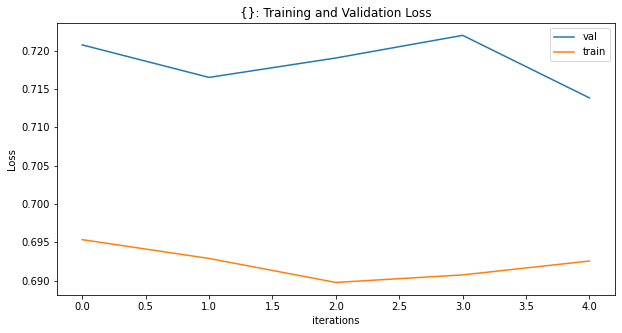

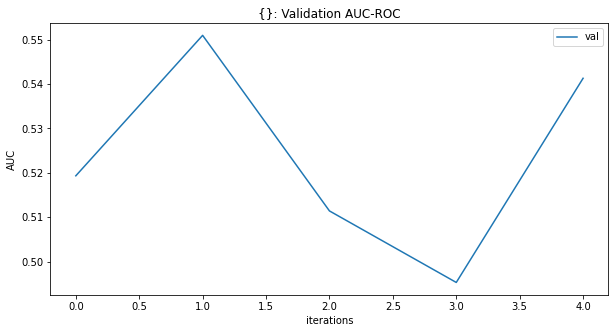

Predict: FLAIR (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,FLAIR
7,11,1,FLAIR
16,24,0,FLAIR
21,31,1,FLAIR
25,36,0,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,FLAIR
7,11,1,FLAIR
16,24,0,FLAIR
21,31,1,FLAIR
25,36,0,FLAIR


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6934, time: 250.00 s
[Epoch Valid: 1] loss: 0.7235, auc: 0.3404, time: 63.00 s
auc improved from 0.0000 to 0.3404. Saved model to 'models/FLAIR-e1-loss0.724-auc0.340.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6883, time: 249.00 s
[Epoch Valid: 2] loss: 0.7084, auc: 0.5762, time: 64.00 s
auc improved from 0.3404 to 0.5762. Saved model to 'models/FLAIR-e2-loss0.708-auc0.576.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6915, time: 238.00 s
[Epoch Valid: 3] loss: 0.7061, auc: 0.5928, time: 64.00 s
auc improved from 0.5762 to 0.5928. Saved model to 'models/FLAIR-e3-loss0.706-auc0.593.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6959, time: 246.00 s
[Epoch Valid: 4] loss: 0.7031, auc: 0.5812, time: 66.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6950, time: 232.00 s
[Epoch Valid: 5] loss: 0.7170, auc: 0.3788, time: 63.00 s


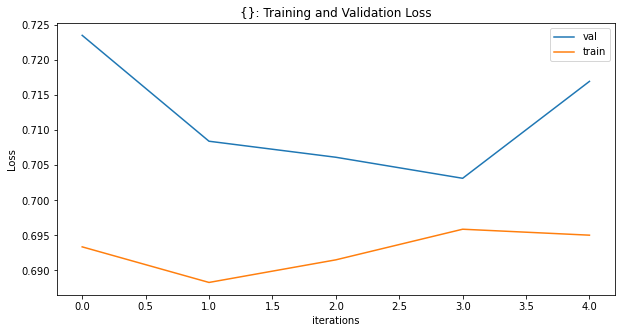

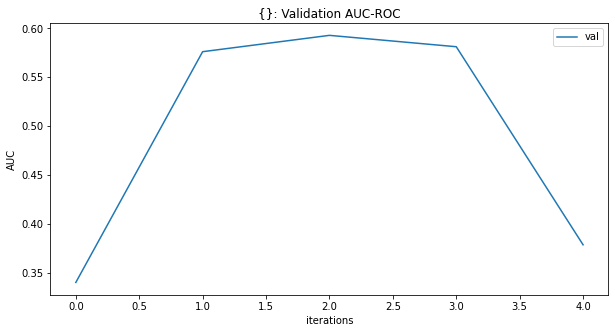

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,FLAIR
6,9,0,FLAIR
8,12,1,FLAIR
27,44,0,FLAIR
36,58,1,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,FLAIR
6,9,0,FLAIR
8,12,1,FLAIR
27,44,0,FLAIR
36,58,1,FLAIR


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6985, time: 246.00 s
[Epoch Valid: 1] loss: 0.7098, auc: 0.4817, time: 59.00 s
auc improved from 0.0000 to 0.4817. Saved model to 'models/FLAIR-e1-loss0.710-auc0.482.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6979, time: 253.00 s
[Epoch Valid: 2] loss: 0.6975, auc: 0.6405, time: 66.00 s
auc improved from 0.4817 to 0.6405. Saved model to 'models/FLAIR-e2-loss0.697-auc0.641.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6932, time: 248.00 s
[Epoch Valid: 3] loss: 0.7188, auc: 0.4656, time: 72.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6900, time: 242.00 s
[Epoch Valid: 4] loss: 0.7087, auc: 0.5428, time: 60.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6910, time: 244.00 s
[Epoch Valid: 5] loss: 0.6977, auc: 0.5422, time: 65.00 s


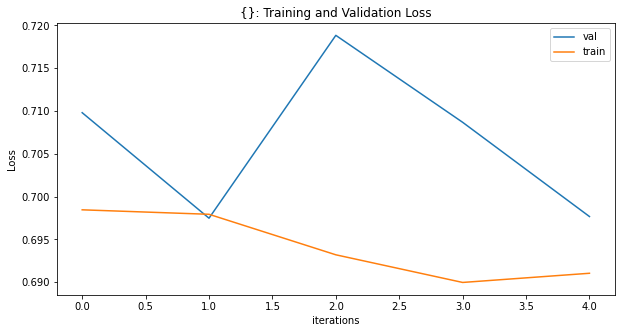

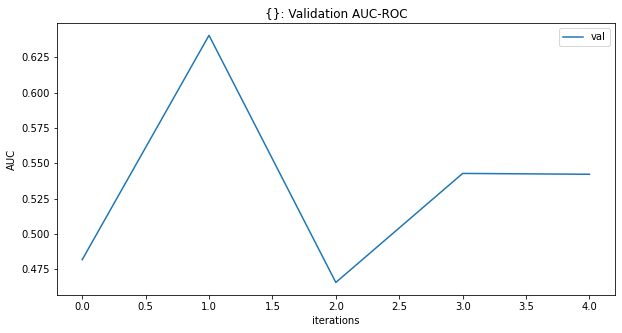

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,FLAIR
3,5,1,FLAIR
5,8,1,FLAIR
10,17,0,FLAIR
13,20,1,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,FLAIR
3,5,1,FLAIR
5,8,1,FLAIR
10,17,0,FLAIR
13,20,1,FLAIR


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6932, time: 242.00 s
[Epoch Valid: 1] loss: 0.7177, auc: 0.5031, time: 62.00 s
auc improved from 0.0000 to 0.5031. Saved model to 'models/FLAIR-e1-loss0.718-auc0.503.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6881, time: 245.00 s
[Epoch Valid: 2] loss: 0.7076, auc: 0.5493, time: 67.00 s
auc improved from 0.5031 to 0.5493. Saved model to 'models/FLAIR-e2-loss0.708-auc0.549.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6889, time: 237.00 s
[Epoch Valid: 3] loss: 0.7089, auc: 0.5246, time: 66.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6896, time: 247.00 s
[Epoch Valid: 4] loss: 0.7237, auc: 0.4703, time: 60.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6920, time: 246.00 s
[Epoch Valid: 5] loss: 0.7133, auc: 0.5142, time: 56.00 s


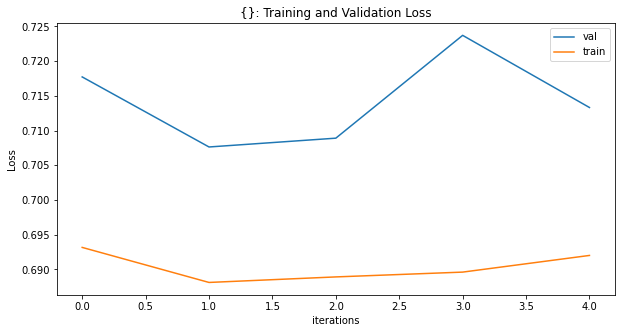

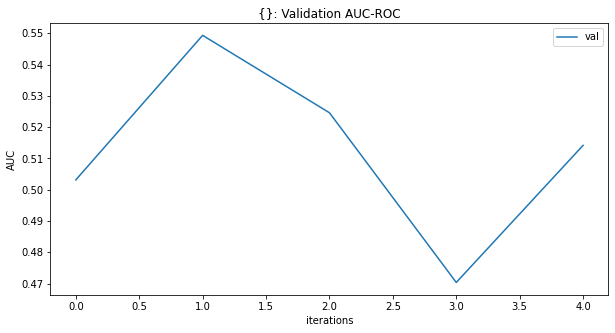

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1w
9,14,1,T1w
11,18,0,T1w
18,26,1,T1w
24,35,1,T1w


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1w
9,14,1,T1w
11,18,0,T1w
18,26,1,T1w
24,35,1,T1w


117
EPOCH: 1
[Epoch Train: 1] loss: 0.7012, time: 253.00 s
[Epoch Valid: 1] loss: 0.7191, auc: 0.4930, time: 61.00 s
auc improved from 0.0000 to 0.4930. Saved model to 'models/T1w-e1-loss0.719-auc0.493.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6990, time: 224.00 s
[Epoch Valid: 2] loss: 0.7262, auc: 0.5589, time: 55.00 s
auc improved from 0.4930 to 0.5589. Saved model to 'models/T1w-e2-loss0.726-auc0.559.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6967, time: 232.00 s
[Epoch Valid: 3] loss: 0.7269, auc: 0.4996, time: 65.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6965, time: 239.00 s
[Epoch Valid: 4] loss: 0.7206, auc: 0.5265, time: 57.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6933, time: 243.00 s
[Epoch Valid: 5] loss: 0.7276, auc: 0.5128, time: 47.00 s


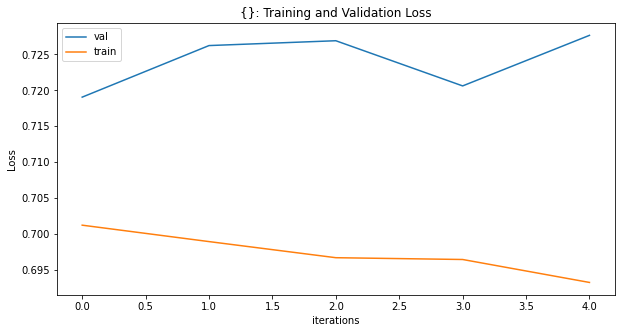

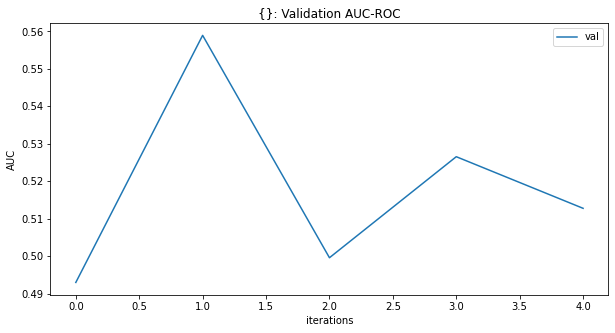

Predict: T1w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,T1w
20,30,0,T1w
22,32,0,T1w
32,52,1,T1w
39,61,0,T1w


465


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,T1w
20,30,0,T1w
22,32,0,T1w
32,52,1,T1w
39,61,0,T1w


117
EPOCH: 1
[Epoch Train: 1] loss: 0.6978, time: 236.00 s
[Epoch Valid: 1] loss: 0.7100, auc: 0.5117, time: 62.00 s
auc improved from 0.0000 to 0.5117. Saved model to 'models/T1w-e1-loss0.710-auc0.512.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6957, time: 223.00 s
[Epoch Valid: 2] loss: 0.6975, auc: 0.6077, time: 62.00 s
auc improved from 0.5117 to 0.6077. Saved model to 'models/T1w-e2-loss0.698-auc0.608.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6958, time: 241.00 s
[Epoch Valid: 3] loss: 0.7007, auc: 0.5556, time: 60.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6952, time: 232.00 s
[Epoch Valid: 4] loss: 0.7131, auc: 0.5474, time: 55.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6939, time: 235.00 s
[Epoch Valid: 5] loss: 0.7137, auc: 0.5454, time: 64.00 s


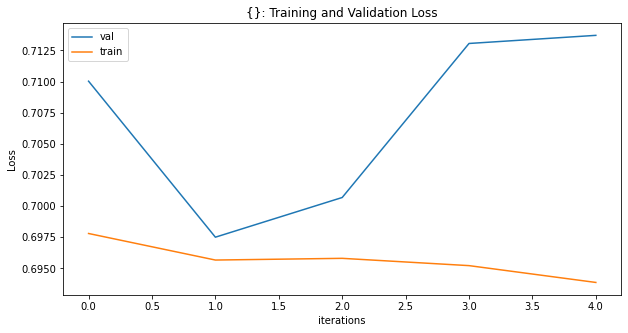

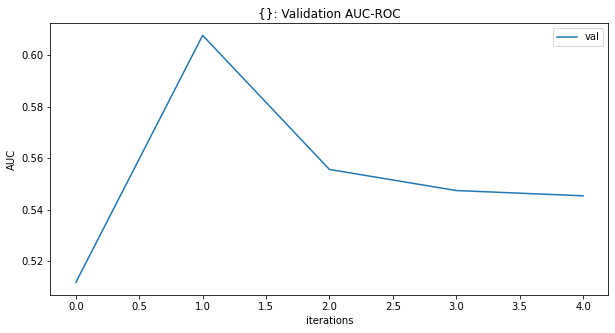

Predict: T1w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1w
7,11,1,T1w
16,24,0,T1w
21,31,1,T1w
25,36,0,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1w
7,11,1,T1w
16,24,0,T1w
21,31,1,T1w
25,36,0,T1w


116
EPOCH: 1
[Epoch Train: 1] loss: 0.7198, time: 249.00 s
[Epoch Valid: 1] loss: 0.7028, auc: 0.4572, time: 59.00 s
auc improved from 0.0000 to 0.4572. Saved model to 'models/T1w-e1-loss0.703-auc0.457.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7184, time: 250.00 s
[Epoch Valid: 2] loss: 0.7045, auc: 0.4745, time: 65.00 s
auc improved from 0.4572 to 0.4745. Saved model to 'models/T1w-e2-loss0.705-auc0.475.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.7128, time: 243.00 s
[Epoch Valid: 3] loss: 0.6981, auc: 0.5654, time: 62.00 s
auc improved from 0.4745 to 0.5654. Saved model to 'models/T1w-e3-loss0.698-auc0.565.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.7066, time: 253.00 s
[Epoch Valid: 4] loss: 0.7014, auc: 0.5449, time: 65.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.7027, time: 238.00 s
[Epoch Valid: 5] loss: 0.7064, auc: 0.5481, time: 63.00 s


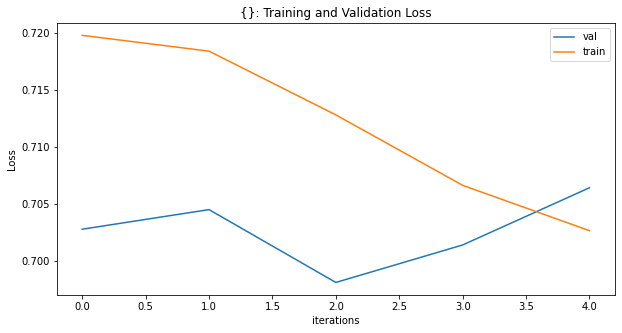

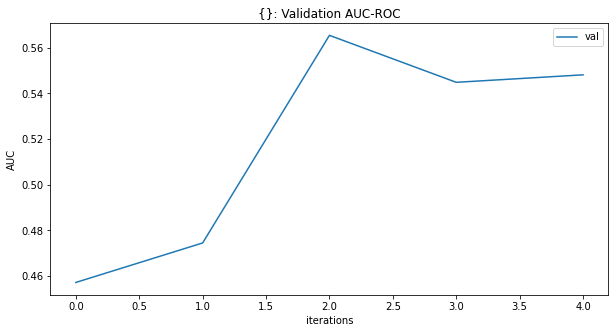

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1w
6,9,0,T1w
8,12,1,T1w
27,44,0,T1w
36,58,1,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1w
6,9,0,T1w
8,12,1,T1w
27,44,0,T1w
36,58,1,T1w


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6909, time: 235.00 s
[Epoch Valid: 1] loss: 0.7269, auc: 0.5010, time: 57.00 s
auc improved from 0.0000 to 0.5010. Saved model to 'models/T1w-e1-loss0.727-auc0.501.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6904, time: 239.00 s
[Epoch Valid: 2] loss: 0.7260, auc: 0.5085, time: 62.00 s
auc improved from 0.5010 to 0.5085. Saved model to 'models/T1w-e2-loss0.726-auc0.508.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6946, time: 241.00 s
[Epoch Valid: 3] loss: 0.7222, auc: 0.4940, time: 58.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6920, time: 246.00 s
[Epoch Valid: 4] loss: 0.7401, auc: 0.4569, time: 56.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6923, time: 241.00 s
[Epoch Valid: 5] loss: 0.7293, auc: 0.4778, time: 62.00 s


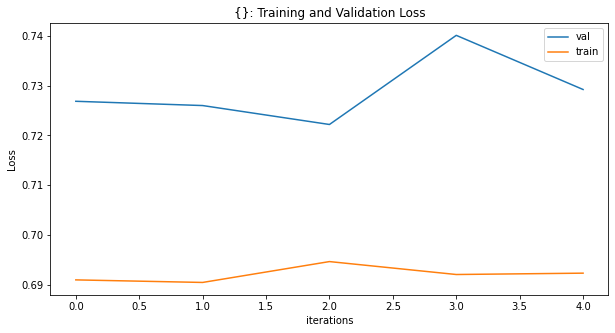

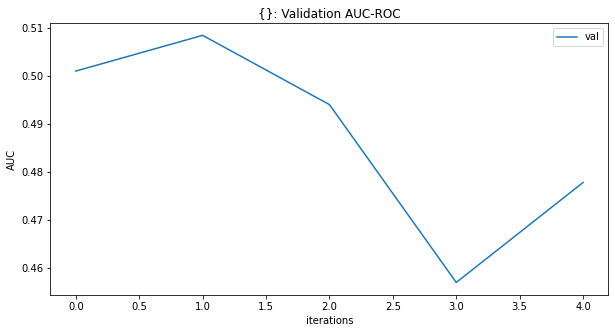

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,T1w
3,5,1,T1w
5,8,1,T1w
10,17,0,T1w
13,20,1,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,T1w
3,5,1,T1w
5,8,1,T1w
10,17,0,T1w
13,20,1,T1w


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6939, time: 236.00 s
[Epoch Valid: 1] loss: 0.7164, auc: 0.4736, time: 60.00 s
auc improved from 0.0000 to 0.4736. Saved model to 'models/T1w-e1-loss0.716-auc0.474.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6910, time: 237.00 s
[Epoch Valid: 2] loss: 0.7244, auc: 0.4999, time: 59.00 s
auc improved from 0.4736 to 0.4999. Saved model to 'models/T1w-e2-loss0.724-auc0.500.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6911, time: 248.00 s
[Epoch Valid: 3] loss: 0.7188, auc: 0.4855, time: 60.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6930, time: 244.00 s
[Epoch Valid: 4] loss: 0.7282, auc: 0.5162, time: 62.00 s
auc improved from 0.4999 to 0.5162. Saved model to 'models/T1w-e4-loss0.728-auc0.516.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.6929, time: 246.00 s
[Epoch Valid: 5] loss: 0.7385, auc: 0.4510, time: 64.00 s


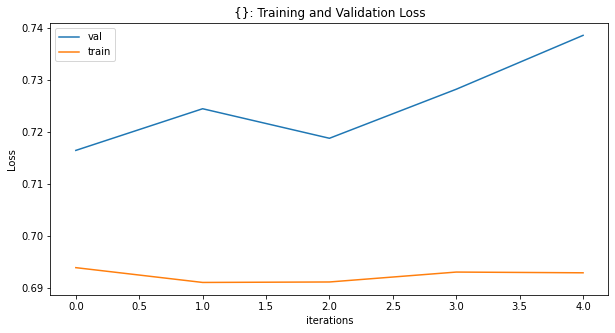

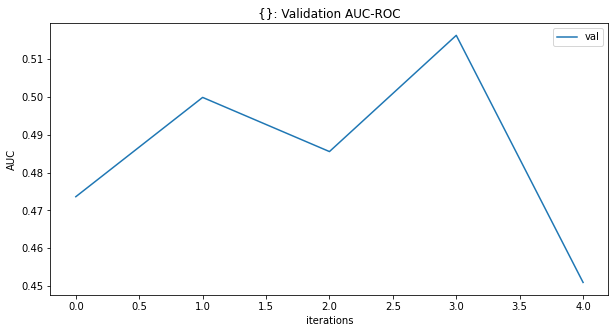

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1wCE
9,14,1,T1wCE
11,18,0,T1wCE
18,26,1,T1wCE
24,35,1,T1wCE


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1wCE
9,14,1,T1wCE
11,18,0,T1wCE
18,26,1,T1wCE
24,35,1,T1wCE


117
EPOCH: 1
[Epoch Train: 1] loss: 0.6920, time: 238.00 s
[Epoch Valid: 1] loss: 0.7082, auc: 0.5164, time: 58.00 s
auc improved from 0.0000 to 0.5164. Saved model to 'models/T1wCE-e1-loss0.708-auc0.516.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6905, time: 239.00 s
[Epoch Valid: 2] loss: 0.7204, auc: 0.4384, time: 65.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.6908, time: 242.00 s
[Epoch Valid: 3] loss: 0.7080, auc: 0.5806, time: 65.00 s
auc improved from 0.5164 to 0.5806. Saved model to 'models/T1wCE-e3-loss0.708-auc0.581.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6945, time: 238.00 s
[Epoch Valid: 4] loss: 0.7130, auc: 0.4358, time: 65.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6892, time: 244.00 s
[Epoch Valid: 5] loss: 0.7222, auc: 0.3903, time: 68.00 s


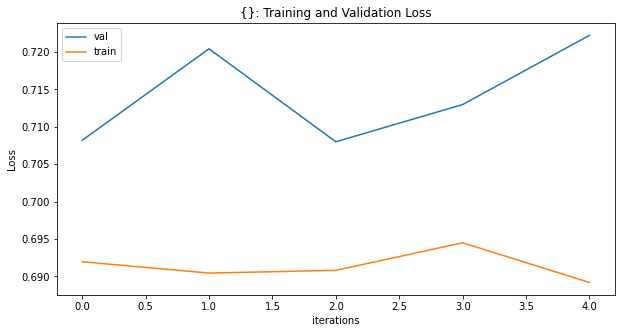

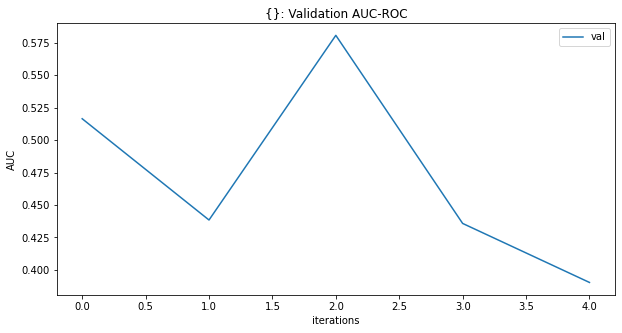

Predict: T1wCE (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,T1wCE
20,30,0,T1wCE
22,32,0,T1wCE
32,52,1,T1wCE
39,61,0,T1wCE


465


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,T1wCE
20,30,0,T1wCE
22,32,0,T1wCE
32,52,1,T1wCE
39,61,0,T1wCE


117
EPOCH: 1
[Epoch Train: 1] loss: 0.6962, time: 240.00 s
[Epoch Valid: 1] loss: 0.7094, auc: 0.5102, time: 63.00 s
auc improved from 0.0000 to 0.5102. Saved model to 'models/T1wCE-e1-loss0.709-auc0.510.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6932, time: 248.00 s
[Epoch Valid: 2] loss: 0.7098, auc: 0.4912, time: 59.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.6932, time: 233.00 s
[Epoch Valid: 3] loss: 0.6980, auc: 0.5240, time: 63.00 s
auc improved from 0.5102 to 0.5240. Saved model to 'models/T1wCE-e3-loss0.698-auc0.524.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6950, time: 238.00 s
[Epoch Valid: 4] loss: 0.7098, auc: 0.5673, time: 65.00 s
auc improved from 0.5240 to 0.5673. Saved model to 'models/T1wCE-e4-loss0.710-auc0.567.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.6921, time: 237.00 s
[Epoch Valid: 5] loss: 0.7070, auc: 0.5345, time: 62.00 s


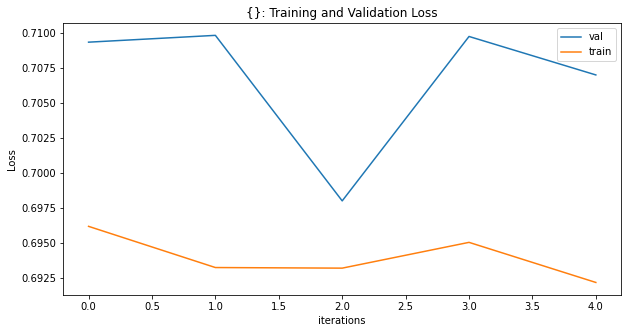

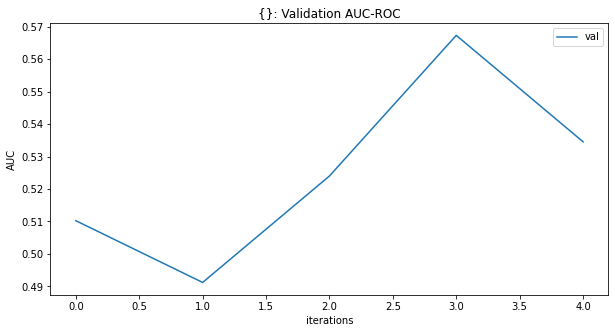

Predict: T1wCE (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1wCE
7,11,1,T1wCE
16,24,0,T1wCE
21,31,1,T1wCE
25,36,0,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1wCE
7,11,1,T1wCE
16,24,0,T1wCE
21,31,1,T1wCE
25,36,0,T1wCE


116
EPOCH: 1
[Epoch Train: 1] loss: 0.7041, time: 236.00 s
[Epoch Valid: 1] loss: 0.7028, auc: 0.5052, time: 59.00 s
auc improved from 0.0000 to 0.5052. Saved model to 'models/T1wCE-e1-loss0.703-auc0.505.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7036, time: 236.00 s
[Epoch Valid: 2] loss: 0.7070, auc: 0.4617, time: 73.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.7010, time: 228.00 s
[Epoch Valid: 3] loss: 0.6936, auc: 0.6167, time: 66.00 s
auc improved from 0.5052 to 0.6167. Saved model to 'models/T1wCE-e3-loss0.694-auc0.617.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6964, time: 248.00 s
[Epoch Valid: 4] loss: 0.7012, auc: 0.5782, time: 58.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6976, time: 249.00 s
[Epoch Valid: 5] loss: 0.7010, auc: 0.5750, time: 60.00 s


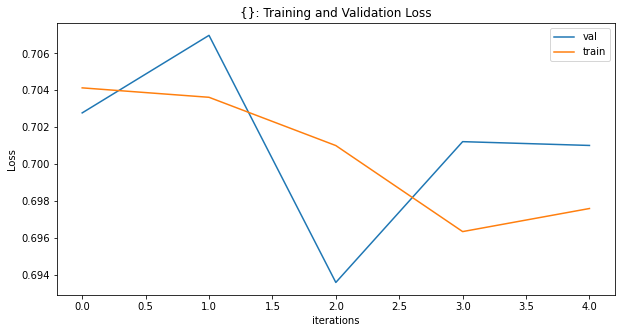

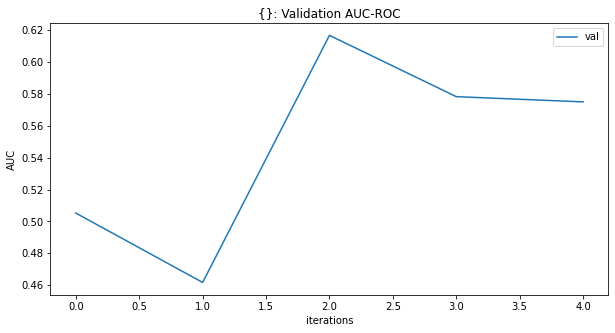

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1wCE
6,9,0,T1wCE
8,12,1,T1wCE
27,44,0,T1wCE
36,58,1,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1wCE
6,9,0,T1wCE
8,12,1,T1wCE
27,44,0,T1wCE
36,58,1,T1wCE


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6937, time: 236.00 s
[Epoch Valid: 1] loss: 0.7155, auc: 0.4978, time: 59.00 s
auc improved from 0.0000 to 0.4978. Saved model to 'models/T1wCE-e1-loss0.715-auc0.498.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6936, time: 243.00 s
[Epoch Valid: 2] loss: 0.7166, auc: 0.5642, time: 56.00 s
auc improved from 0.4978 to 0.5642. Saved model to 'models/T1wCE-e2-loss0.717-auc0.564.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6911, time: 249.00 s
[Epoch Valid: 3] loss: 0.7095, auc: 0.5669, time: 67.00 s
auc improved from 0.5642 to 0.5669. Saved model to 'models/T1wCE-e3-loss0.710-auc0.567.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6943, time: 244.00 s
[Epoch Valid: 4] loss: 0.7111, auc: 0.5541, time: 59.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6900, time: 248.00 s
[Epoch Valid: 5] loss: 0.7088, auc: 0.5586, time: 57.00 s


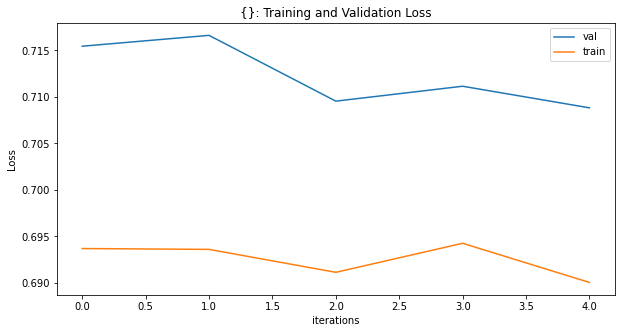

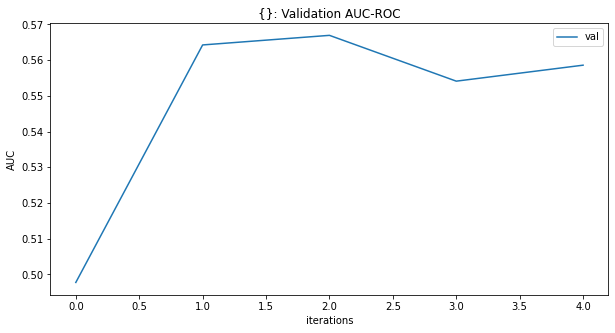

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,T1wCE
3,5,1,T1wCE
5,8,1,T1wCE
10,17,0,T1wCE
13,20,1,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,T1wCE
3,5,1,T1wCE
5,8,1,T1wCE
10,17,0,T1wCE
13,20,1,T1wCE


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6945, time: 234.00 s
[Epoch Valid: 1] loss: 0.7125, auc: 0.4578, time: 57.00 s
auc improved from 0.0000 to 0.4578. Saved model to 'models/T1wCE-e1-loss0.713-auc0.458.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6986, time: 229.00 s
[Epoch Valid: 2] loss: 0.7099, auc: 0.4727, time: 59.00 s
auc improved from 0.4578 to 0.4727. Saved model to 'models/T1wCE-e2-loss0.710-auc0.473.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.6962, time: 239.00 s
[Epoch Valid: 3] loss: 0.7077, auc: 0.5326, time: 65.00 s
auc improved from 0.4727 to 0.5326. Saved model to 'models/T1wCE-e3-loss0.708-auc0.533.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6927, time: 240.00 s
[Epoch Valid: 4] loss: 0.7128, auc: 0.4560, time: 58.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6930, time: 242.00 s
[Epoch Valid: 5] loss: 0.7017, auc: 0.5586, time: 64.00 s
auc improved from 0.5326 to 0.5586. Saved model to 'models/T1wCE-e5-loss0.702-auc0.559.pth'


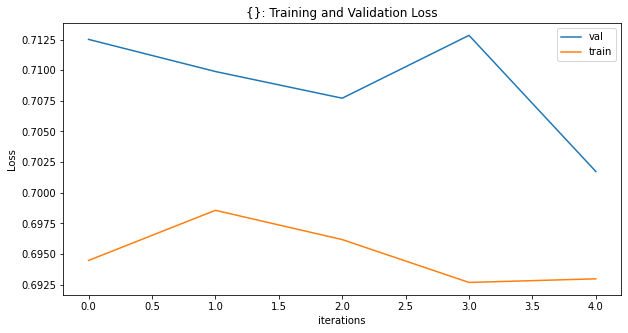

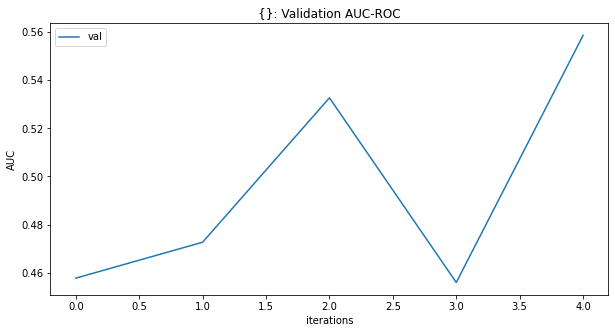

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T2w
9,14,1,T2w
11,18,0,T2w
18,26,1,T2w
24,35,1,T2w


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T2w
9,14,1,T2w
11,18,0,T2w
18,26,1,T2w
24,35,1,T2w


117
EPOCH: 1
[Epoch Train: 1] loss: 0.7254, time: 238.00 s
[Epoch Valid: 1] loss: 0.6957, auc: 0.5155, time: 63.00 s
auc improved from 0.0000 to 0.5155. Saved model to 'models/T2w-e1-loss0.696-auc0.516.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7223, time: 257.00 s
[Epoch Valid: 2] loss: 0.6942, auc: 0.5191, time: 63.00 s
auc improved from 0.5155 to 0.5191. Saved model to 'models/T2w-e2-loss0.694-auc0.519.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.7146, time: 255.00 s
[Epoch Valid: 3] loss: 0.7073, auc: 0.5566, time: 59.00 s
auc improved from 0.5191 to 0.5566. Saved model to 'models/T2w-e3-loss0.707-auc0.557.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.7093, time: 258.00 s
[Epoch Valid: 4] loss: 0.7027, auc: 0.5328, time: 66.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.7045, time: 243.00 s
[Epoch Valid: 5] loss: 0.7023, auc: 0.4507, time: 62.00 s


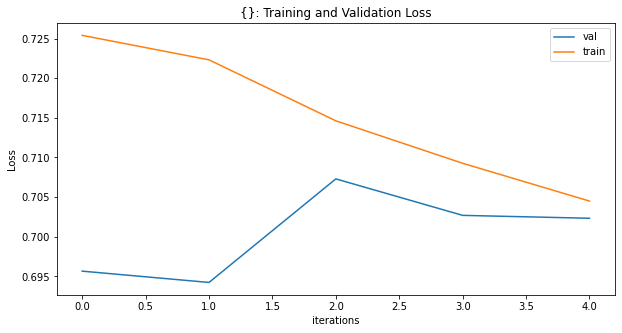

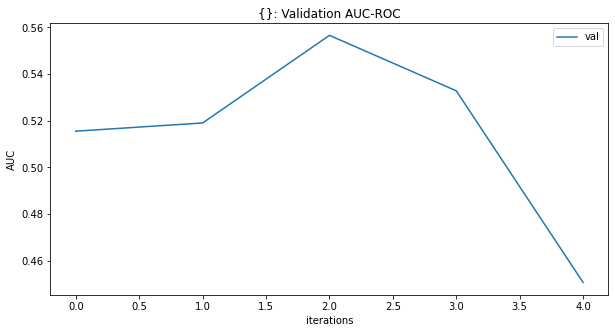

Predict: T2w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,T2w
20,30,0,T2w
22,32,0,T2w
32,52,1,T2w
39,61,0,T2w


465


,BraTS21ID,MGMT_value,MRI_Type
12,19,0,T2w
20,30,0,T2w
22,32,0,T2w
32,52,1,T2w
39,61,0,T2w


117
EPOCH: 1
[Epoch Train: 1] loss: 0.6948, time: 238.00 s
[Epoch Valid: 1] loss: 0.7285, auc: 0.4871, time: 66.00 s
auc improved from 0.0000 to 0.4871. Saved model to 'models/T2w-e1-loss0.729-auc0.487.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6923, time: 233.00 s
[Epoch Valid: 2] loss: 0.7264, auc: 0.4438, time: 58.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.6943, time: 234.00 s
[Epoch Valid: 3] loss: 0.7269, auc: 0.4760, time: 63.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6915, time: 239.00 s
[Epoch Valid: 4] loss: 0.7312, auc: 0.4057, time: 61.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6938, time: 242.00 s
[Epoch Valid: 5] loss: 0.7277, auc: 0.4778, time: 58.00 s


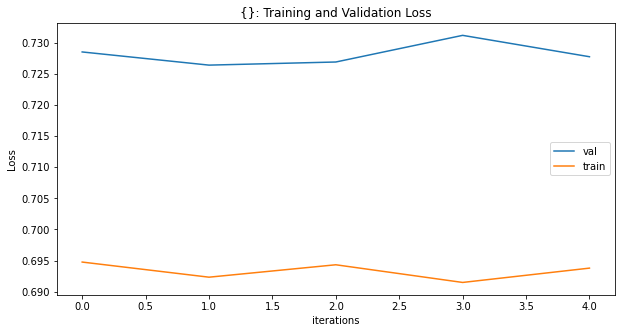

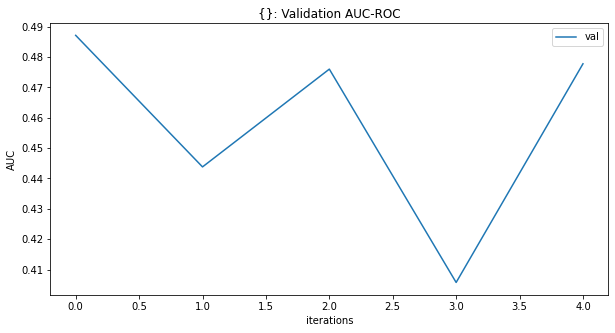

Predict: T2w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T2w
7,11,1,T2w
16,24,0,T2w
21,31,1,T2w
25,36,0,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T2w
7,11,1,T2w
16,24,0,T2w
21,31,1,T2w
25,36,0,T2w


116
EPOCH: 1
[Epoch Train: 1] loss: 0.6981, time: 230.00 s
[Epoch Valid: 1] loss: 0.7057, auc: 0.5791, time: 63.00 s
auc improved from 0.0000 to 0.5791. Saved model to 'models/T2w-e1-loss0.706-auc0.579.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6950, time: 246.00 s
[Epoch Valid: 2] loss: 0.7081, auc: 0.5058, time: 59.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.6913, time: 252.00 s
[Epoch Valid: 3] loss: 0.7074, auc: 0.5365, time: 59.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6926, time: 243.00 s
[Epoch Valid: 4] loss: 0.7177, auc: 0.4423, time: 62.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6955, time: 231.00 s
[Epoch Valid: 5] loss: 0.7143, auc: 0.5487, time: 59.00 s


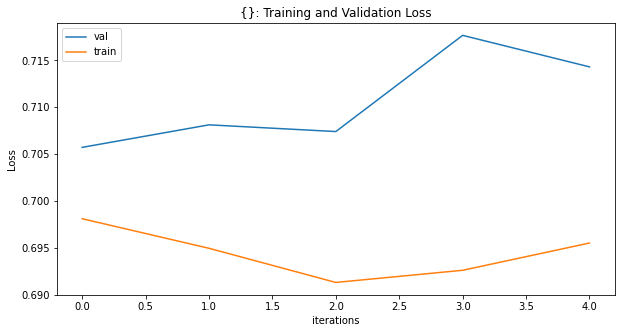

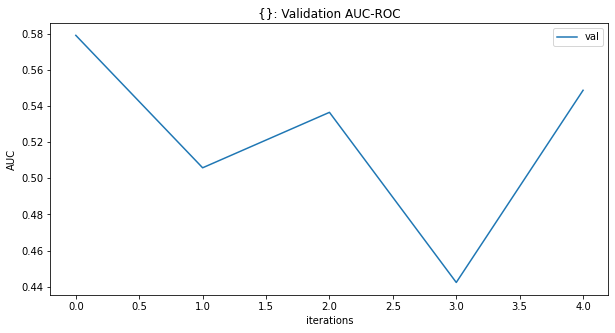

Predict: T2w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T2w
6,9,0,T2w
8,12,1,T2w
27,44,0,T2w
36,58,1,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T2w
6,9,0,T2w
8,12,1,T2w
27,44,0,T2w
36,58,1,T2w


116
EPOCH: 1
[Epoch Train: 1] loss: 0.7004, time: 231.00 s
[Epoch Valid: 1] loss: 0.7214, auc: 0.5717, time: 64.00 s
auc improved from 0.0000 to 0.5717. Saved model to 'models/T2w-e1-loss0.721-auc0.572.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6983, time: 237.00 s
[Epoch Valid: 2] loss: 0.7190, auc: 0.4641, time: 57.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.6961, time: 229.00 s
[Epoch Valid: 3] loss: 0.7128, auc: 0.5812, time: 57.00 s
auc improved from 0.5717 to 0.5812. Saved model to 'models/T2w-e3-loss0.713-auc0.581.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.6942, time: 242.00 s
[Epoch Valid: 4] loss: 0.7191, auc: 0.5192, time: 60.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6938, time: 241.00 s
[Epoch Valid: 5] loss: 0.7284, auc: 0.4465, time: 57.00 s


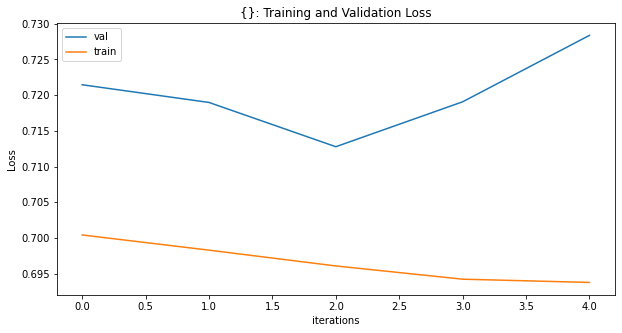

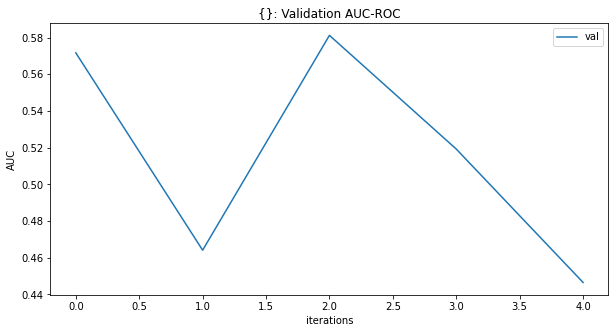

Predict: T2w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,T2w
3,5,1,T2w
5,8,1,T2w
10,17,0,T2w
13,20,1,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
1,2,1,T2w
3,5,1,T2w
5,8,1,T2w
10,17,0,T2w
13,20,1,T2w


116
EPOCH: 1
[Epoch Train: 1] loss: 0.7176, time: 239.00 s
[Epoch Valid: 1] loss: 0.7085, auc: 0.4942, time: 58.00 s
auc improved from 0.0000 to 0.4942. Saved model to 'models/T2w-e1-loss0.708-auc0.494.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7106, time: 240.00 s
[Epoch Valid: 2] loss: 0.7073, auc: 0.4984, time: 57.00 s
auc improved from 0.4942 to 0.4984. Saved model to 'models/T2w-e2-loss0.707-auc0.498.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.7058, time: 238.00 s
[Epoch Valid: 3] loss: 0.7111, auc: 0.5079, time: 56.00 s
auc improved from 0.4984 to 0.5079. Saved model to 'models/T2w-e3-loss0.711-auc0.508.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.7023, time: 235.00 s
[Epoch Valid: 4] loss: 0.7014, auc: 0.5928, time: 57.00 s
auc improved from 0.5079 to 0.5928. Saved model to 'models/T2w-e4-loss0.701-auc0.593.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.6986, time: 237.00 s
[Epoch Valid: 5] loss: 0.7093, auc: 0.5854, time: 65.00 s


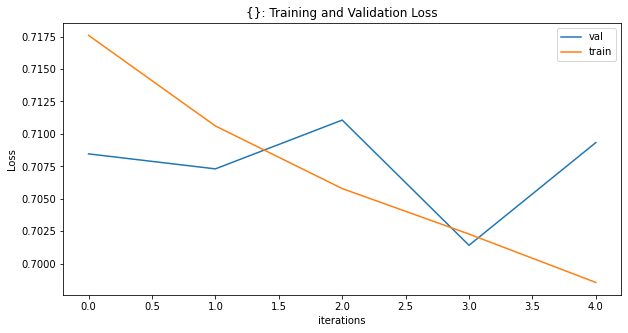

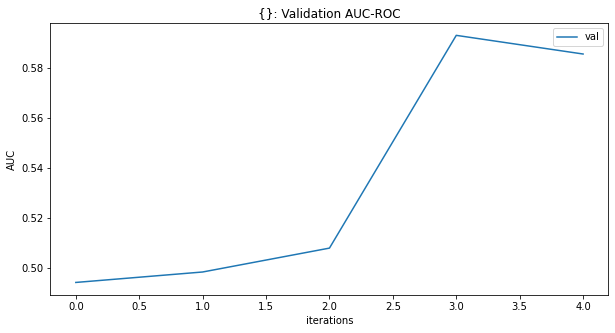

Predict: T2w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
CPU times: user 12h 2min 44s, sys: 56min 58s, total: 12h 59min 43s
Wall time: 8h 35min 56s


In [17]:
%%time

oof_train = []
oof_test = []
modelfiles = []

for mri_type in mri_types:
    trn, tst, modelfile = train_mri_type(df, df_test, mri_type, rkf)
    oof_train.append(trn)
    oof_test.append(tst)
    modelfiles.append(modelfile)

In [298]:
x_train = np.swapaxes(np.array(oof_train), 0, 1)
x_test = np.swapaxes(np.array(oof_test), 0, 1)

In [299]:
len(df), len(x_train), len(x_test)

(582, 582, 87)

In [300]:
df_test = pd.read_csv(f"{data_directory}/sample_submission.csv")

In [301]:
for i, mri_type in enumerate(mri_types):
    df[f"level0_{mri_type}_preds"] = x_train[:, i]
    df_test[f"level0_{mri_type}_preds"] = x_test[:, i]

In [303]:
y = df["MGMT_value"].values
X = df.drop(["MGMT_value"], axis=1)

In [304]:
params = {
    'learning_rate': [0.03, 0.01, 0.005],
    'n_estimators': [1000, 5000, 10000, 20000],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [305]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [306]:
gbc = xgb.XGBClassifier(
    objective='binary:logistic',
)

In [307]:
folds = 5
param_comb = 20

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

random_search = RandomizedSearchCV(
    gbc,
    param_distributions=params,
    n_iter=param_comb,
    scoring='roc_auc',
    n_jobs=8,
    cv=skf.split(X, y),
    verbose=10,
    random_state=1001,
    use_label_encoder=False
)

random_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f76ff417ac0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=20, n_jobs=8,
                   

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[CV 4/5; 1/20] START colsample_bytree=0.8, gamma=5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=0.8
[17:59:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 1/20] END colsample_bytree=0.8, gamma=5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=0.8;, score=0.408 total time=   8.5s
[CV 5/5; 2/20] START colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=4, min_child_weight=10, n_estimators=20000, subsample=0.8
[17:59:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 2/20] END colsample_bytree=0.6, gamma

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[CV 2/5; 1/20] START colsample_bytree=0.8, gamma=5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=0.8
[17:59:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 1/20] END colsample_bytree=0.8, gamma=5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=0.8;, score=0.473 total time=   8.2s
[CV 4/5; 2/20] START colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=4, min_child_weight=10, n_estimators=20000, subsample=0.8
[17:59:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 2/20] END colsample_bytree=0.6, gamma

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[CV 3/5; 2/20] START colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=4, min_child_weight=10, n_estimators=20000, subsample=0.8
[17:59:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 2/20] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=4, min_child_weight=10, n_estimators=20000, subsample=0.8;, score=0.536 total time= 2.1min
[CV 5/5; 3/20] START colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=3, min_child_weight=1, n_estimators=20000, subsample=1.0
[18:01:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 3/20] END colsample_bytree=0

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[CV 1/5; 1/20] START colsample_bytree=0.8, gamma=5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=0.8
[17:59:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 1/20] END colsample_bytree=0.8, gamma=5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=0.8;, score=0.565 total time=   8.7s
[CV 2/5; 3/20] START colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=3, min_child_weight=1, n_estimators=20000, subsample=1.0
[17:59:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 3/20] END colsample_bytree=0.6, gamma=

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[CV 1/5; 2/20] START colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=4, min_child_weight=10, n_estimators=20000, subsample=0.8
[17:59:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 2/20] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.005, max_depth=4, min_child_weight=10, n_estimators=20000, subsample=0.8;, score=0.542 total time= 2.2min
[CV 3/5; 4/20] START colsample_bytree=0.8, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=5000, subsample=0.8
[18:01:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 4/20] END colsample_bytree=0.8, 

In [308]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([  8.45945172, 128.59850683, 117.41013484,  37.23838453,
       148.21885076,  35.02557316,  28.78415365, 144.61310549,
        66.04030118, 153.94238405,  30.7680419 ,   6.09051623,
       118.02095752,   9.68533225,  91.58562684,  42.63578987,
         5.63228321,   7.54920316,  28.26178298,  21.18094015]), 'std_fit_time': array([ 0.19811682,  3.22622819,  4.9090115 ,  2.27998609,  2.10127114,
        2.15048501,  3.34122675,  7.4021175 ,  5.23772357, 10.16585642,
        1.36103495,  0.26658426,  5.17889558,  1.05495977,  6.34927054,
        3.05479598,  0.48150815,  0.49532012,  2.02593115,  7.93609103]), 'mean_score_time': array([0.05082045, 0.16510553, 0.10070386, 0.08195767, 0.12110496,
       0.10722175, 0.0931139 , 0.08993969, 0.07313018, 0.16143746,
       0.0744483 , 0.04271483, 0.08335099, 0.07417793, 0.0867589 ,
       0.06744432, 0.07890992, 0.05788221, 0.08633633, 0.03667912]), 'std_score_time': array([0.029465  , 0.04332207, 0.0130

In [361]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.459452,0.198117,0.050820,0.029465,0.8,1000,1,4,0.03,5,0.8,"{'subsample': 0.8, 'n_estimators': 1000, 'min_...",0.565103,0.473361,0.528465,0.408048,0.407154,0.476426,0.063333,13
1,128.598507,3.226228,0.165106,0.043322,0.8,20000,10,4,0.005,0.5,0.6,"{'subsample': 0.8, 'n_estimators': 20000, 'min...",0.542229,0.464578,0.535618,0.407154,0.490909,0.488098,0.049601,6
2,117.410135,4.909012,0.100704,0.013065,1.0,20000,1,3,0.005,0.5,0.6,"{'subsample': 1.0, 'n_estimators': 20000, 'min...",0.569795,0.516101,0.539493,0.416095,0.445604,0.497418,0.057716,3
3,37.238385,2.279986,0.081958,0.016057,0.8,5000,5,4,0.03,1,0.8,"{'subsample': 0.8, 'n_estimators': 5000, 'min_...",0.534604,0.490925,0.512966,0.415797,0.462593,0.483377,0.041366,11
4,148.218851,2.101271,0.121105,0.035816,0.8,20000,10,5,0.005,2,0.6,"{'subsample': 0.8, 'n_estimators': 20000, 'min...",0.544428,0.458724,0.528465,0.402981,0.500149,0.486949,0.051086,7
5,35.025573,2.150485,0.107222,0.015298,0.6,5000,10,4,0.005,1,0.6,"{'subsample': 0.6, 'n_estimators': 5000, 'min_...",0.541496,0.435304,0.560656,0.403875,0.521610,0.492588,0.061675,5
6,28.784154,3.341227,0.093114,0.023365,0.6,5000,1,3,0.005,1.5,0.6,"{'subsample': 0.6, 'n_estimators': 5000, 'min_...",0.536950,0.462822,0.533234,0.409538,0.420864,0.472682,0.053975,14
7,144.613105,7.402118,0.089940,0.024264,0.6,20000,5,4,0.01,5,0.6,"{'subsample': 0.6, 'n_estimators': 20000, 'min...",0.553372,0.459309,0.528763,0.399702,0.476900,0.483609,0.054003,10
8,66.040301,5.237724,0.073130,0.011225,1.0,10000,1,3,0.005,5,1.0,"{'subsample': 1.0, 'n_estimators': 10000, 'min...",0.550000,0.507611,0.568703,0.511475,0.476751,0.522908,0.032638,1
9,153.942384,10.165856,0.161437,0.021183,0.6,20000,1,4,0.005,1.5,0.6,"{'subsample': 0.6, 'n_estimators': 20000, 'min...",0.518768,0.475995,0.516841,0.407154,0.422951,0.468342,0.046385,18


In [346]:
x_test = df_test.copy()
x_test = x_test.drop(["MGMT_value"], axis=1)

In [358]:
test_preds = random_search.predict_proba(x_test)

In [359]:
test_preds = test_preds[:,1]
test_preds[:4]

array([0.5456323, 0.5456323, 0.5456323, 0.5456323], dtype=float32)

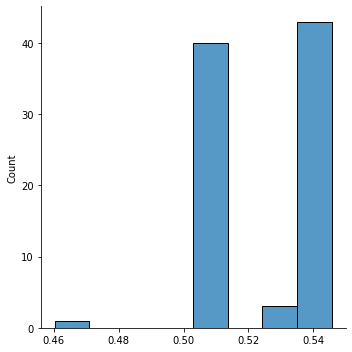

In [360]:
# auc = roc_auc_score(y_valid, val_preds)
# print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(test_preds)

**Submission**

In [185]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv")
submission["MGMT_value"] = test_preds
submission.to_csv("submission.csv")